<div>
<img src="https://i.ibb.co/v3CvVz9/udd-short.png" width="150"/>
    <br>
    <strong>Universidad del Desarrollo</strong><br>
    <em>Magíster en Data Science</em><br>
    <em>Profesora: María Paz Raveau Morales</em><br>

</div>

# **<center>TAREA 2 COMPARANDO TOPIC MODELING Y CLUSTERING</center>**
*03 de agosto de 2025*

**Nombre Estudiante**: Cristian Tobar Morales  
**Asignatura**: Procesamiento de Lenguaje Natural


## **DESCRIPCIÓN DE LA PROBLEMÁTICA**
 

## **OBJETIVOS**

## **DESARROLLO**

### **CARGA Y ANÁLISIS EXPLORATORIO DE LOS DATOS**

#### Librerías requeridas

In [1]:
import os
%matplotlib inline
import pandas as pd
import numpy as np
import math


import string
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud
from nltk import bigrams

remove_punct_map = dict.fromkeys(map(ord, string.punctuation))
pd.set_option('display.max_rows',1000)
pd.set_option('display.max_columns',1000)
from itertools import compress

import re

# visualización 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import stanza
stanza.download('es') # Ejecutar solamente una vez
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma,depparse')

2025-08-03 16:40:51 INFO: Downloaded file to C:\Users\crist\stanza_resources\resources.json
2025-08-03 16:40:51 INFO: Downloading default packages for language: es (Spanish) ...
2025-08-03 16:40:57 INFO: File exists: C:\Users\crist\stanza_resources\es\default.zip
2025-08-03 16:41:03 INFO: Finished downloading models and saved to C:\Users\crist\stanza_resources
2025-08-03 16:41:03 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2025-08-03 16:41:04 INFO: Downloaded file to C:\Users\crist\stanza_resources\resources.json
2025-08-03 16:41:05 INFO: Loading these models for language: es (Spanish):
| Processor | Package           |
---------------------------------
| tokenize  | combined          |
| mwt       | combined          |
| pos       | combined_charlm   |
| lemma     | combined_nocharlm |
| depparse  | combined_charlm   |

2025-08-03 16:41:05 INFO: Using device: cpu
2025-08-03 16:41:05 INFO: Loading: tokenize
2025-08-03 16:42:05 INFO: Loading: mwt
2025-08-03 16:42:05 INFO: Loading: pos
2025-08-03 16:42:08 INFO: Loading: lemma
2025-08-03 16:42:09 INFO: Loading: depparse
2025-08-03 16:42:10 INFO: Done loading processors!


In [3]:
import nltk
nltk.download('punkt') # Ejecutar solamente una vez

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\crist\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from nltk import word_tokenize
from nltk.corpus import stopwords
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop + ['ser','tener','deber','haber','hacer','poder','ir']
esp_stop.remove('estado')
esp_stop.remove('estados')

In [5]:
import gensim
from gensim import corpora
from gensim import models

#### Cargar e Información inicial del dataset

In [79]:
# Leer cada línea como una entrada de texto
with open('ecqq.csv', encoding='utf-8') as f:
    lines = f.readlines() # lee el archivo completo como una lista de líneas

# Limpiar saltos de línea y espacios
lines = [line.strip() for line in lines if line.strip()]

# Crear DataFrame con una sola columna
df = pd.DataFrame(lines, columns=['texto'])

In [80]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10204 entries, 0 to 10203
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   texto   10204 non-null  object
dtypes: object(1)
memory usage: 79.8+ KB


In [81]:
# Exploración inicial
df['texto'].head().to_list()

['P2_1_B',
 '0\tse necesitan pensiones dignas a los adultos mayores, ya que no alcanza el costo de vida tan alto en que que vivimos',
 '1\tel acceso a la salud sea de calidad, con diagnosticos que generen confianza no debiendo ir a santiago para conseguir confianza. altos costos de los servicios.',
 '2\t"conprender que el trabajo es una ""actividad"" y no un ""lugar físico"", a partir de ello, la incorporación de la flexibilidad laboral permite generar mayor motivación.',
 'junto con ello, asimilar a trabajadores honorarios como aquellos que cuentan con cto indefinido y no como trabajadores de 2° categori"']

Se seleccionan distintas filas del corpus con el objetivo de revisar la data cruda y comprender el tipo de información compartida, como paso previo al procesamiento.

In [47]:
import random

for i in range(8):
    print(f"\033[1m TEXTO {i}:\033[0m")
    print(df.loc[random.randint(0, len(df))]['texto'], end="\n")

 TEXTO 0:
3792	pensiones dignas, que nos permitan vivir dignidad, pensiones actuales no nos permiten llegar el mundo de la culturas, cine, libros , porque se nos esta vetando
 TEXTO 1:
4074	"- urgencia, no es urgencia
 TEXTO 2:
demora en examen (servicios)
 TEXTO 3:
2978	"mala reforma de pensiones no esta de acuerdo con el aumento
 TEXTO 4:
956	"-salud pública no permite que las personas puedan atenderse oportunamente y salud digna.
 TEXTO 5:
1314	"educación digna y de calidad que sea transversal
 TEXTO 6:
1110	"que se potencia a carabineros y se renueve completamente.
 TEXTO 7:
- Mecanismo de rentabilidad estable


En las filas seleccionadas de forma aleatoria se observa que los ciudadanos realizan solicitudes al Estado sobre su calidad de vida, ya sea para llevar una existencia tranquila y digna o para acceder a una pensión adecuada.

### **PRE-PROCESAMIENTO**

In [82]:
# Crear una nueva columna
columna = "texto_modificado"
df[columna] = df['texto']

In [83]:
# Saber que entradas no aportan información
df[columna].value_counts().head(15)

texto_modificado
"                           109
falta de especialistas        8
-falta de especialistas       6
especialistas                 5
- falta de especialistas      5
falta de especialistas.       5
- mas especialistas           4
- falta de insumos            3
lista de espera               3
listas de espera              3
-falta de medicamentos        3
- falta de especialista       3
-"                            3
- lista de espera             3
- calidad                     3
Name: count, dtype: int64

In [84]:
# Eliminar las filas que no aportar información
"""
Se procede a eliminar las filas (")
"""
df= df[(df[columna].str.strip() != '"') & (df[columna].str.strip() != '-"')]

df[columna].value_counts().head(15)

texto_modificado
falta de especialistas      8
-falta de especialistas     6
- falta de especialistas    5
falta de especialistas.     5
especialistas               5
- mas especialistas         4
lista de espera             3
- falta de especialista     3
- calidad                   3
- lista de espera           3
listas de espera            3
- falta de insumos          3
-falta de medicamentos      3
mala atención.              2
mejor atención              2
Name: count, dtype: int64

In [85]:
# Eliminar la primera fila
# Quitar la fila 0
df = df[df[columna] != 'P2_1_B']

In [86]:
# Obtener valores únicos
df.drop_duplicates(
    subset=[columna],
    keep='first', # Conserva la primera ocurrencia
    inplace= True
)
print("\u001b[1mDIMENSIONES\u001b[0m")
df.shape

DIMENSIONES


(9988, 2)

#### Tokenizar

In [87]:
corpus = ' '.join(df[columna].to_list()) # Unir el texto con un espacio y to_list, obtiene la lista
doc =  set(word_tokenize(corpus))
largo = len(doc)
# imprimir
print(f"Tokens únicos: {largo}")


Tokens únicos: 13435


#### Lemmatizar

In [88]:
def lemmatizer(text):
    doc = nlp(text)
    return ' '.join([
        word.lemma 
        for sent in doc.sentences
            for word in sent.words
                if word.lemma not in esp_stop])

In [89]:
df[columna]= df[columna].apply(lemmatizer)

#### Transformar el texto en minúsculas, eliminar puntuaciones, números, espacios en blanco y salto de líneas

In [90]:
# Transformar a minúscula
df[columna] = df[columna].str.lower()

# Eliminar las puntuaciones: '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
df[columna] = df[columna].str.translate(str.maketrans('','', string.punctuation))

# Eliminar números
df[columna] = df[columna].str.translate(str.maketrans('', '', string.digits))

# Eliminar espacios en blanco
df[columna] = df[columna].str.strip()

# Reemplazar saltos de líneas por espacios
df[columna] = df[columna].str.replace('\n',' ')

In [91]:
df.shape

(9988, 2)

In [92]:
df[columna].head().to_list()

['necesitar pensión digno adulto mayor  alcanzar costo vida alto vivir',
 'acceso salud calidad  diagnostico generar confianza santiago conseguir confianza  alto costo servicio',
 'conprender trabajo   actividad     lugar físico    partir  incorporación flexibilidad laboral permitir generar mayor motivación',
 'junto  asimilar trabajador honorario aquel contar cto indefinido trabajador ° categori',
 'especialista consultorio  escaso llevar hora espera interminable']

#### Stopwords

In [93]:
# Tokenizar el texto
tokens = set(word_tokenize(' '.join(df[columna].to_list())))

# Eliminar Stopwords
filtrado = [x for x in tokens if x not in esp_stop]

len(filtrado)

4991

Se procede al guardado del archivo preprocesado.

In [94]:
df.to_csv('ecqq_preprocesados.csv', sep='\t')

In [6]:
# Cargar el nuevo dataset
df_limpio = pd.read_csv('ecqq_preprocesados.csv',sep='\t',index_col=0)

Comparar el conjunto de datos original con el preprocesado es fundamental para evaluar la eficacia y exhaustividad del proceso de limpieza de datos.

In [11]:
df_limpio.head()

,texto,texto_modificado
1,0\tse necesitan pensiones dignas a los adultos...,necesitar pensión digno adulto mayor alcanzar...
2,"1\tel acceso a la salud sea de calidad, con di...",acceso salud calidad diagnostico generar conf...
3,"2\t""conprender que el trabajo es una """"activid...",conprender trabajo actividad lugar físic...
4,"junto con ello, asimilar a trabajadores honora...",junto asimilar trabajador honorario aquel con...
5,"3\t""- más especialistas en los consultorios, s...",especialista consultorio escaso llevar hora e...


In [12]:
df_limpio['texto'].head().to_list()

['0\tse necesitan pensiones dignas a los adultos mayores, ya que no alcanza el costo de vida tan alto en que que vivimos',
 '1\tel acceso a la salud sea de calidad, con diagnosticos que generen confianza no debiendo ir a santiago para conseguir confianza. altos costos de los servicios.',
 '2\t"conprender que el trabajo es una ""actividad"" y no un ""lugar físico"", a partir de ello, la incorporación de la flexibilidad laboral permite generar mayor motivación.',
 'junto con ello, asimilar a trabajadores honorarios como aquellos que cuentan con cto indefinido y no como trabajadores de 2° categori"',
 '3\t"- más especialistas en los consultorios, son escasos lo que lleva a horas de espera interminables']

In [14]:
df_limpio['texto_modificado'].head().to_list()

['necesitar pensión digno adulto mayor  alcanzar costo vida alto vivir',
 'acceso salud calidad  diagnostico generar confianza santiago conseguir confianza  alto costo servicio',
 'conprender trabajo   actividad     lugar físico    partir  incorporación flexibilidad laboral permitir generar mayor motivación',
 'junto  asimilar trabajador honorario aquel contar cto indefinido trabajador ° categori',
 'especialista consultorio  escaso llevar hora espera interminable']

In [16]:
import random
for i in range(10):
    print(f"\033[1m TEXTO {i}:\033[0m")
    print(df_limpio.loc[random.randint(0, len(df_limpio))]['texto_modificado'], end="\n")

 TEXTO 0:
cada especialista tomar rol corresponder acuerdo función
 TEXTO 1:
mejorar dar aporte económico
 TEXTO 2:
indolencia  falta empatía profesional salud
 TEXTO 3:
garantizar plan salud bajo costo
 TEXTO 4:
salud igualitario derecho salud gratuito fin lista espera
 TEXTO 5:
reconfianza politico
 TEXTO 6:
partido politico dividido buscar bien comun
 TEXTO 7:
que dirigente generar acuerdo beneficiar  arreglar siempre
 TEXTO 8:
importante buen hospital faltar especialista recurso  remedio execibamente caro
 TEXTO 9:
vez remedio examen


In [7]:
print(df_limpio['texto_modificado'].isna().sum())    # cuenta de NaN
df_limpio.dropna(subset=['texto_modificado'], inplace=True)

16


### **MODELO LDA INCORPORANDO BIGRAMAS**

In [8]:
from gensim.models import Phrases

# Creación de bigramas
corpus = [word_tokenize(doc) for doc in df_limpio['texto_modificado']]

bigram = Phrases(corpus, min_count=1, threshold=1) # min_count, ignora bigramas con menos de 5 apariciones

for x in range(len(corpus)):
    for token in bigram[corpus[x]]:
        if '_' in token:
            corpus[x].append(token) # Agrega el token al corpus

In [ ]:
# Imprime los primeros 3 documentos completos
for i, doc in enumerate(corpus[:4]):
    print(f"--- Documento {i} ---")
    print(doc, end="\n\n")

--- Documento 0 ---
['necesitar', 'pensión', 'digno', 'adulto', 'mayor', 'alcanzar', 'costo', 'vida', 'alto', 'vivir', 'pensión_digno', 'adulto_mayor', 'costo_vida']

--- Documento 1 ---
['acceso', 'salud', 'calidad', 'diagnostico', 'generar', 'confianza', 'santiago', 'conseguir', 'confianza', 'alto', 'costo', 'servicio', 'acceso_salud', 'alto_costo']

--- Documento 2 ---
['conprender', 'trabajo', 'actividad', 'lugar', 'físico', 'partir', 'incorporación', 'flexibilidad', 'laboral', 'permitir', 'generar', 'mayor', 'motivación', 'flexibilidad_laboral', 'permitir_generar']

--- Documento 3 ---
['junto', 'asimilar', 'trabajador', 'honorario', 'aquel', 'contar', 'cto', 'indefinido', 'trabajador', '°', 'categori']



In [10]:
from collections import Counter
all_bigrams = [
    token
    for doc in corpus # Recorre cada documento
    for token in doc # Recorre cada token dentro del documento
    if "_" in token # Filtra los que tienen "_"
]

freq_counter = Counter(all_bigrams)

# Mostrar los 10 bigramas más comunes
print("\033[1m--- Listado de bigramas ordenados ascendentemente ---\033[0m")
for bigram, freq in freq_counter.most_common(15):
    print(f"{bigram}: {freq}")

--- Listado de bigramas ordenados ascendentemente ---
lista_espera: 214
adulto_mayor: 184
malo_atención: 111
mejorar_calidad: 106
mejorar_atención: 102
falta_especialista: 100
salud_público: 93
sistema_salud: 78
mejor_atención: 74
mejorar_sistema: 70
tiempo_espera: 60
pensión_digno: 58
salud_calidad: 55
acceso_salud: 54
mejorar_salud: 54


In [11]:
# Remove rare and common tokens.
from gensim.corpora import Dictionary

# Create a dictionary representation of the documents.
diccionario = Dictionary(corpus)

In [ ]:
# Matriz documento-término (DTM)
dtm_gensim = [diccionario.doc2bow(i) for i in corpus]

In [13]:
print(dtm_gensim[0])


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1)]


In [14]:
print('Número único de tokens: %d' % len(diccionario))
print('Número de documentos: %d' % len(dtm_gensim))

Número único de tokens: 8549
Número de documentos: 9972


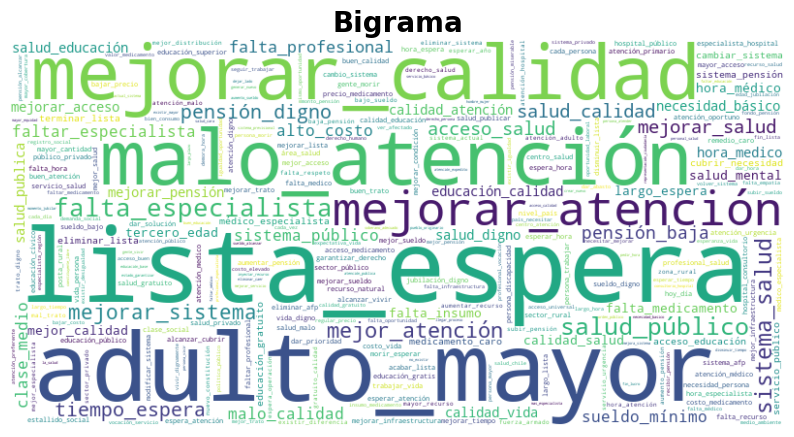

In [16]:
# Visualización del bigrama
from collections import Counter
freq_counter

wc = WordCloud(
    background_color='white',
    width=800,
    height=400,
    max_words=8549
).generate_from_frequencies(freq_counter)

# Mostrar
plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Bigrama', fontsize=20, fontweight='bold')
plt.show()